- essaye k-moyenne avec softmax, mais trop lent pour executer

  (environ 6 min par rapport a environ 1min pour kmoyen simple avec k = 10)

In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

from scipy.spatial import distance

In [2]:
def sep_ponct(my_str, rule = r"[.,?!]"): #rule = r"([.,?!])" pour garder les ponctuations
    """separer les mots avec les char de ponctuation"""
    #print(my_str)
    sp0 = re.split(rule, my_str)
    sp1 = [data.strip() for data in sp0]
    res = [data for data in sp1 if (data != '') ]
   
    return res

In [3]:
data=pd.read_csv('data.tsv',sep='\t')
dataQ=data.Question
dataA=data.Answer
Q=[]
A=[]
Q2W=[]# liste de mots pour chaque phrase 
A2W=[]
for i in range(len(dataQ)):
    Q.append(dataQ[i].lower())
for each in Q: 
    each_list = sep_ponct(each)
    remisEsp = ' '.join(each_list)
    Q2W.append(remisEsp.split(" "))
for i in range(len(dataA)):
    A.append(dataA[i].lower())
for each in A:
    each_list = sep_ponct(each)
    remisEsp = ' '.join(each_list)
    A2W.append(remisEsp.split(" "))

In [4]:
data.describe()

,Question,Answer
count,10559,10559
unique,10191,826
top,Tell me a joke,It's nice to have things you love.
freq,46,299


In [5]:
import gensim, logging

In [6]:
window_size=2
N=len(Q2W)
vector_size=3
tout=Q2W+A2W
model=gensim.models.Word2Vec(tout,vector_size=vector_size, window=2, min_count=1, workers=4)

In [7]:
from spellchecker import SpellChecker

In [8]:
def motInconnu(mot):
    try:
        model.wv.get_vector(mot.lower())   
    except:
        spell = SpellChecker()
        mot=str(mot)
        #model.build_vocab([[str(mot)]], update=True)
        #UpdateMatrice
        print("We can't understand this word ",mot,". Do you want to say this word ",'\'',spell.correction(mot),'\'')
        print("Please enter the correct word ! ")
        x = str(input())
        return x,False
    return mot,True
        
        
"""a,b=motInconnu("name")
a"""
#false: le mot entre est le correct  

'a,b=motInconnu("name")\na'

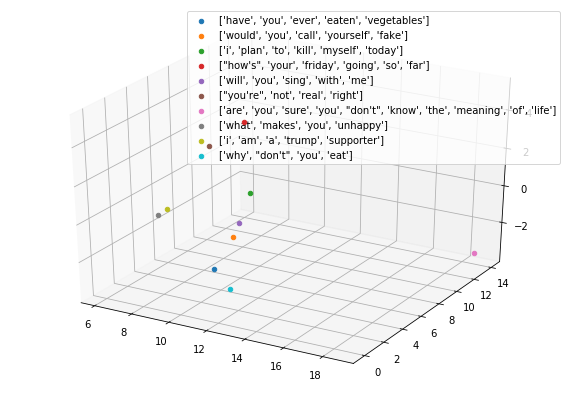

In [9]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
V=[]
for i in range (N):
    s=np.zeros(vector_size)
    for j in range(len(Q2W[i])):
        motInconnu(Q2W[i][j])
        wv=np.array(model.wv.get_vector(Q2W[i][j]))
        s+=wv
    V.append(list(s))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
for i in range(10):
    ax.scatter3D(V[i][0],V[i][1],V[i][2],label=Q2W[i])
    #ax.scatter3D(V[i][0],V[i][1],V[i][2])
plt.legend()


In [10]:
class KmoyennesSoft:

    def __init__(self,K,IterationMax): ## instanciation d'un objet du type de la classe.
        self.K = K
        self.N = 0
        self.D = 0
        self.IterationMax = IterationMax
        self.affectations = np.zeros((self.N,self.K))
        self.representants = np.zeros((self.K,self.D))
        self.softmax = np.zeros((self.N,self.K))
             
    def dist(self,x1,x2):
            return np.sum((x1-x2)**2)**0.5
    
    def fit(self,X, funDist= dist):
        self.N = X.shape[0]
        self.D = X.shape[1]
        representants_initiaux = np.random.random((self.K,self.D))
        
        self.representants = representants_initiaux     
        
        ## boucle (comme plus haut)
        for  i in range(self.IterationMax):
            softmax, affectations = self.maj_affectations(X, self.representants, funDist)
            self.representants = self.maj_representants(X, softmax, affectations)
            #print(i, representants)
                     
        ## on affecte le resultat dans les variables membres de la classe.
        #self.representants = representants
        #print( self.representants)
        self.softmax = softmax
        self.affectations = affectations
        return self.representants,self.affectations
        
    #softmax  
    def softMax(self, Xn,l,r,funDist, beta =1):
        
        numerateur =  np.exp(-beta*funDist(Xn,r[l]))
        somme = 0
        for k in range(self.K):
            somme += np.exp(-beta*funDist(Xn,r[k]))
        return numerateur/somme
        

    def barycentre(self,X, soft, oldcenter):
        Nselection = X.shape[0]
        if Nselection != 0:
             resultat = np.dot(soft,X)/Nselection
        else:
             resultat = oldcenter
        return resultat
    
    def maj_affectations(self, X, r, cosDist):
        s = np.zeros((self.N,self.K))
        a = np.zeros((self.N,self.K))
        for n in range(self.N):
            for k in range(self.K):
                s[n,k] = self.softMax(X[n], k,r, cosDist)
            gr = np.argmax(s[n])
            a[n,gr] = 1

        return s,a

    def maj_representants(self, X, s,a):
        ## une fonction peut etre membre de la classe, ou peut etre accessible depuis seulement une fonction.
        r = np.zeros((self.K,self.D))
        for group in range(self.K):
            masque = a[:,group] == 1
            r[group] = self.barycentre(X[masque], s[masque][:,group],self.representants[group]) # la facon typique d'appeler une fonction de la classe depuis la classe
               
        return r
    
    def drawGr(self,X,fig):
        for gr in range(self.K):
            g0 = (self.affectations[:,gr] ==1)
            plt.scatter(X[g0,0],X[g0,1], label = f"group {gr}")
        plt.plot(self.representants[:,0],self.representants[:,1], 'r+', label = 'representant')

X=np.array(V)
K=10
Km = Kmoyennes(K=K, IterationMax=10)
Km.fit(X=X)
affectations = Km.affectations
representants = Km.representants

#print(affectations,representants)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
G=[]
for k in range(K):
    g0 = affectations==k
    G.append(X[g0])
    ax.scatter3D(X[g0,0],X[g0,1],X[g0,2],label=Q2W[k])
plt.legend()


def classifier(X,K,model = KmoyennesSoft, iterMax=10 ):
    Km = model(K=K, IterationMax=iterMax)
    Km.fit(X=X)
    affectations = Km.affectations
    representants = Km.representants
    return affectations, representants

In [11]:
X=np.array(V)
K = 10
Km = KmoyennesSoft(K=K, IterationMax=10)

representants,affectations = Km.fit(X=X, funDist = distance.cosine)

[10.30366293  2.8028139  -2.57043651]


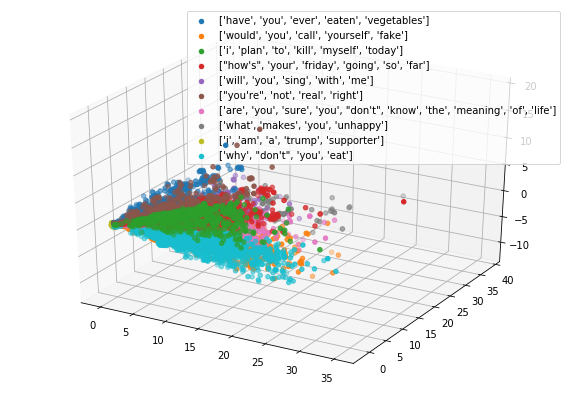

In [12]:
print(X[0])
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
G=[]
for k in range(K):
    g0 = affectations[:,k] ==1
    G.append(X[g0])
    ax.scatter3D(X[g0,0],X[g0,1],X[g0,2],label=Q2W[k])
plt.legend()


In [13]:
def nearestVector(vector,groupe):
    minimum=distance.cosine(groupe[0],vector)
    index=0
    for i in range(len(vector)):
        vector[i]=float(vector[i])
    for i in range(len(groupe)):
        #print(distance.cosine(groupe[i],vector))
        if (distance.cosine(groupe[i],vector)<minimum):
            minumum=distance.cosine(vector,groupe[i])
            index=i
    return index              

In [14]:
def getQVsomme(tab):
    s=np.zeros(vector_size)
    for each in tab:      
        wv=np.array(model.wv.get_vector(each))
        s+=wv
    return list(s)

In [15]:
#ratio_train = 0.8
ratio_test = 0.2
#et pour valid dataset ??

Nv = len(V)
Nt = int(Nv*ratio_test)
Ntrain =  Nv- Nt
print("test size = ", Nt, "\ndata size = ", Nv)

X_test = np.array(V[-Nt:].copy())
X_train = np.array(V[0:Ntrain].copy())

X_test.shape, X_train.shape

test size =  2111 
data size =  10559


((2111, 3), (8448, 3))

In [16]:
seuil=0.06
def chatbot(question):
    Q=question.lower()
    
    q = sep_ponct(Q)
    tab = ' '.join(q).split()
    #print("tab= ",tab)
    
    for i in range(len(tab)):
        tab[i],b=motInconnu(tab[i])
        while(b==False):
            tab[i],b=motInconnu(tab[i])
    QV=getQVsomme(tab)
   
    for i in range(len(X_train)):
        if QV==list(X_train[i]):
            nearestIndex=V.index(QV)
            return dataA[nearestIndex]
        
    nearestRepresentants=nearestVector(QV,representants) 
    g0 = affectations[:,nearestRepresentants] == 1
    nearestIndexCloture=nearestVector(QV,X[g0])
    nearestIndex=V.index(list(X[g0][nearestIndexCloture]))
    #print(distance.cosine(list(X[g0][nearestIndexCloture]),QV))
    if(distance.cosine(list(X[g0][nearestIndexCloture]),QV)>seuil):
        return "I am so sorry, I can't give an answer "
    return dataA[nearestIndex] 


#0.07307243670603059: distance what's your name vs answer 
#0.06816835295193202: distance red vs orange

In [17]:
def letsChat():
    goodBye = ['bye', 'goodbye','have a nice day','see you']
    print("Ask me something! ")
    chat = True
    while(chat):
        Q = str(input()) #entrer une phrase
        if(Q.lower() in goodBye):
            print(Q)
            return
        answer = chatbot(Q)
        print(answer)   

In [19]:
#18h11-18h17 pour executer les cellules au dessus, surtout pour Km.fit()

In [18]:
letsChat()